<a href="https://colab.research.google.com/github/cc-ca/Human_action_understanding/blob/clip/Clip_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CLIP to classify actions in video


This notebook presents classification of human's action in video based on CLIP zero-short transfer learning capabilities.



In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2
import random
import tensorflow as tf
import numpy as np
import subprocess
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Download and Install CLIP Dependencies



In [3]:
# installing some dependencies, CLIP was released in PyTorch

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import torch

print("Torch version:", torch.__version__)

CUDA version: 11.8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, 

In [4]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")

import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (124/124), done.
CLIP dir is: /content/CLIP


In [5]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 127MiB/s]


Model dir: /root/.cache/clip


## Prepare folders

In [6]:
if(not os.path.isdir('video')):
  os.mkdir('video')

if(not os.path.isdir('frames')):
  os.mkdir('frames')
  os.makedirs('frames/no_tag')

In [7]:
def deleteFrames():
  video_paths = os.listdir('./frames/no_tag/')
  for path in video_paths:
    if(path != ".ipynb_checkpoints"):
      os.remove('./frames/no_tag/'+path)


In [8]:
def deleteFolder(folderID):
  folderID = str(folderID)
  video_paths = os.listdir('./frames/'+folderID+'/')
  for path in video_paths:
    if(path != ".ipynb_checkpoints"):
      os.remove('./frames/'+folderID+'/'+path)
  os.rmdir('./frames/'+folderID)


## Functions to prepare images

We will consume images with the help of `ImageFolder` dataset from `PyTorch`.

In [9]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

In [10]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [11]:
def frames_from_video_file(video_path, n_frames, output_size = (244,244), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [12]:
def convert(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  return converted_images

In [13]:
def sample_video(video_paths):
    sample_video = frames_from_video_file(str(video_paths), n_frames = 1)
    sample_video = convert(sample_video[0])
    img = Image.fromarray(sample_video, 'RGB')
    id = random.randint(0,100000)
    filePath = 'frames/no_tag/' +str(id) + ".jpg"
    while(os.path.isfile(filePath)):
      id = id + random.randint(0,100000)
      filePath = 'frames/no_tag/'+ str(id) + ".jpg"
    img.save(filePath)
    return id

In [14]:
def sample_video_multiple_frame(video_paths, n_frame):
    sample_video = frames_from_video_file(video_paths, n_frame)
    sample_video = convert(sample_video)
    id = random.randint(0,100000)
    folderPath = 'frames/'+str(id)
    while(os.path.isdir(folderPath)):
      id = id + random.randint(0,100000)
      folderPath = 'frames/'+str(id)
    os.mkdir('frames/'+str(id))
    index = 0
    for sample in sample_video:
      img = Image.fromarray(sample, 'RGB')
      filePath = folderPath + '/'+ str(index) + ".jpg"
      index += 1  
      img.save(filePath)
    return id

## Predict action of a video

In [15]:
def Accuracy():
  class_names = ['applauding', 'cleaning toilet', 'doing nails', 'opening bottle (not wine)', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes']
  val_dataset = list()
  dataset=dict()
  video_class_predict = dict()
  for class_name in class_names:
    for video in sorted(os.listdir('/content/drive/MyDrive/val/' + class_name)):
      val_dataset.append((video, class_name))
  for video in val_dataset:
    try:
      id = sample_video("/content/drive/MyDrive/dataset/val/"+video[1]+"/"+video[0])
      dataset[str(id)] = video
    except:
      val_dataset.remove(video)
      continue

  class_captions = [f"An image depicting a {x}" for x in class_names]
  text_input = clip.tokenize(class_captions).to(device)

  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  data = ImageFolder(root="./frames", transform=transform)
  data_batches = DataLoader(data, batch_size=len(dataset), shuffle=False) 

  image_input, y_true = next(iter(data_batches))
  image_input = image_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()


  
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  text_probs = np.array(text_probs.cpu())

  index = 0
  frames = sorted(os.listdir('./frames/no_tag'))
  for frame in frames:
    prediction = dict()
    indexs_max = np.argsort(text_probs[index])[::-1][:3]
    i=1
    for index_max in indexs_max:
      if(text_probs[index][index_max] == 0):
        prediction[str(i)] = "None"
      else:
        prediction[str(i)] = class_names[index_max]
      i+=1

    video_class_predict[frame[:len(frame)-4]] = prediction
    index+=1
  
  number_of_prediction_correct_top1 = 0
  number_of_prediction_correct_top3 = 0

  for id in video_class_predict:
    predict = video_class_predict[id]
    if(predict['1'] == dataset[id][1]):
      number_of_prediction_correct_top1 +=1
    elif(predict['2'] == dataset[id][1] or predict['3'] == dataset[id][1]):
      number_of_prediction_correct_top3 +=1

  number_of_prediction_correct_top3 += number_of_prediction_correct_top1
  deleteFrames()
  accuracy = {"Top1":number_of_prediction_correct_top1/len(video_class_predict)*100, "Top3":number_of_prediction_correct_top3/len(video_class_predict)*100} 
  return accuracy, video_class_predict, text_probs

In [30]:
def show_results(image_features, text_features, class_names, dataset):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 20])
    # top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(50, 25))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(8, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(8, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, text_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        # plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()
    

In [17]:
def predict_with_multiple_frame(video_path, class_name ,n_frame):
  video_action_probs = list()
  id = sample_video_multiple_frame(video_path, n_frame)
  #folder_names = sorted(os.listdir('./frames/'))
  #class_to_idx = {class_names[i]: i for i in range(len(folder_names))}
  class_captions = [f"An image depicting a {x}" for x in class_names]
  text_input = clip.tokenize(class_captions).to(device)
  #print(f"Tokens shape: {text_input.shape}")

  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  #print(f"Text features shape: {text_features.shape}")
  dataset = ImageFolder(root="./frames", transform=transform)
  data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False) 

  image_input, y_true = next(iter(data_batches))
  image_input = image_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()


  
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  text_probs = np.array(text_probs.cpu())
  
  for i in range(len(text_probs)):
    index_max = np.argmax(text_probs[i])
    #video_action_probs.append((video_path[i],class_names[index_max]))
    video_action_probs.append(index_max)
  
  video_action_probs = np.array(video_action_probs)
  #show_results(image_features, text_features, class_names, dataset)  
  deleteFrames()
  counts = np.bincount(video_action_probs)
  index_pred = np.argmax(counts)
  deleteFolder(id)
  return class_names[index_pred]


In [18]:
def predict_action(video_path, class_names):
  video_action_probs = list()
  for video in video_path:
    print("./video/"+video)
    sample_video("./video/"+video)
  class_captions = [f"An image depicting a {x}" for x in class_names]
  text_input = clip.tokenize(class_captions).to(device)

  with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  dataset = ImageFolder(root="./frames", transform=transform)
  data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False) 

  image_input, y_true = next(iter(data_batches))
  image_input = image_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  text_probs = np.array(text_probs.cpu())
  
  for i in range(len(text_probs)):
    index_max = np.argmax(text_probs)
    video_action_probs.append(class_names[index_max])
  show_results(image_features, text_features, class_names, dataset)  
  deleteFrames()
  return video_action_probs


In [19]:
class_names = ['applauding', 'cleaning toilet', 'doing nails', 'opening bottle (not wine)', 'petting cat', 'pillow fight', 'playing cards', 'playing guitar', 'smoking', 'stretching arm', 'vacuuming floor', 'washing dishes']

./video/AvvThpYwTQ0_000008_000018.mp4


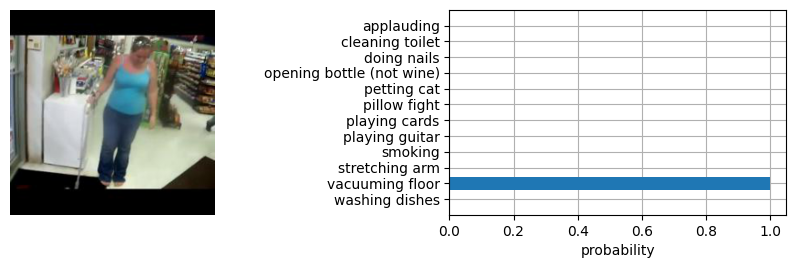

In [31]:
video_names = sorted(os.listdir('./video/'))

if(len(video_names) != 0):
  if(video_names[0] == ".ipynb_checkpoints"):
    video_names.pop(0)
  try:
    video_action_probs = predict_action(video_names, class_names)
  except:
    print("Incorrect files or Error during prediction !")

else:
  print("The folder video is empty. Upload inside video(s) you want to predict !")

In [21]:
#accuracy, predict, probs = Accuracy()
#print(f"Accuracy: TOP1 = {accuracy['Top1']}% ; TOP3 = {accuracy['Top3']}%")

In [22]:
#video_paths = "./video/KMHDg1rBQJk_000015_000025.mp4",n

In [23]:
#n_frame = 10

In [24]:
#test, probs = predict_with_multiple_frame(video_paths, class_names , n_frame)